# Imports

In [3]:
import numpy as np
import pandas as pd
import json
import os
import random
import time
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_curve

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

print("All necessary libraries imported.")

All necessary libraries imported.


In [ ]:
SEED = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

WINDOW_SIZE_FRAMES = 150
STEP_SIZE_FRAMES = 30
BATCH_SIZE = 128

INPUT_FEATURES = 73
HIDDEN_SIZE = 128
NUM_LAYERS = 2
NUM_CLASSES = 2
NUM_EPOCHS = 10

def set_seed(seed_value: int):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"Global seed set to {seed_value}")

def load_and_label_files(data_root: str) -> pd.DataFrame:
    all_csv_files = glob(os.path.join(data_root, '**', '*.csv'), recursive=True)
    labeled_data = [{'path': file_path, 'label': 1 if 'Potential_shoplifter' in file_path else 0} for file_path in all_csv_files]
    df_files = pd.DataFrame(labeled_data)
    print(f"Found {len(df_files)} total CSV files.")
    if not df_files.empty:
        print("\nValue counts for labels:")
        print(df_files['label'].value_counts())
    return df_files

def parse_poses_from_string(poses_str: str) -> np.ndarray:
    try:
        return np.array(json.loads(poses_str)).reshape(18, 2)
    except (json.JSONDecodeError, ValueError):
        return np.zeros((18, 2))

def extract_features(csv_path: str) -> np.ndarray | None:
    df = pd.read_csv(csv_path)
    if df.empty or 'POSES' not in df.columns:
        return None

    raw_poses = np.array(df['POSES'].apply(parse_poses_from_string).tolist())
    neck_positions = raw_poses[:, 1:2, :]
    normalized_poses = raw_poses - neck_positions
    velocities = np.diff(raw_poses, axis=0, prepend=raw_poses[0:1])
    neck_trajectory = raw_poses[:, 1, :]
    deltas = np.diff(neck_trajectory, axis=0, prepend=[neck_trajectory[0]])
    orientation_angles_deg = np.degrees(np.arctan2(deltas[:, 1], deltas[:, 0]))
    return np.concatenate([
        normalized_poses.reshape(raw_poses.shape[0], -1),
        velocities.reshape(raw_poses.shape[0], -1),
        orientation_angles_deg.reshape(-1, 1)
    ], axis=1)

set_seed(SEED)
print(f"Using device: {device}")

data_root = r'C:\Users\asus\Desktop\Ain-Guard Assesment\csvs_Skeleton_poses_normal_potential_shoplifter'

df_files = load_and_label_files(data_root)
df_files.head()

Global seed set to 42
Using device: cpu
Found 152 total CSV files.

Value counts for labels:
label
0    88
1    64
Name: count, dtype: int64


,path,label
0,C:\Users\asus\Desktop\Ain-Guard Assesment\csvs...,0
1,C:\Users\asus\Desktop\Ain-Guard Assesment\csvs...,0
2,C:\Users\asus\Desktop\Ain-Guard Assesment\csvs...,0
3,C:\Users\asus\Desktop\Ain-Guard Assesment\csvs...,0
4,C:\Users\asus\Desktop\Ain-Guard Assesment\csvs...,0


In [ ]:
def get_group_id(file_path: str) -> str:
    return os.path.basename(file_path).replace('.csv', '')[-23:]

def create_sliding_windows(sequences: list, labels: list, window_size: int, step_size: int):
    windowed_sequences, windowed_labels = [], []
    for i, seq in enumerate(sequences):
        if seq.shape[0] >= window_size:
            for start in range(0, seq.shape[0] - window_size + 1, step_size):
                windowed_sequences.append(seq[start:start + window_size])
                windowed_labels.append(labels[i])
    return np.array(windowed_sequences), np.array(windowed_labels)

print(" Processing all CSV files into feature sequences ")

all_sequences, all_labels, all_groups, all_paths = [], [], [], []
for _, row in tqdm(df_files.iterrows(), total=len(df_files), desc="Extracting Features"):
    features = extract_features(row['path'])
    if features is not None and len(features) > 0:
        all_sequences.append(features)
        all_labels.append(row['label'])
        all_groups.append(get_group_id(row['path']))
        all_paths.append(row['path'])

print("\n Splitting data by group to prevent leakage ")

gss_train_temp = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_group_indices, temp_group_indices = next(gss_train_temp.split(all_sequences, all_labels, all_groups))

train_sequences = [all_sequences[i] for i in train_group_indices]
train_labels = [all_labels[i] for i in train_group_indices]

temp_sequences = [all_sequences[i] for i in temp_group_indices]
temp_labels = [all_labels[i] for i in temp_group_indices]
temp_groups = np.array(all_groups)[temp_group_indices]
temp_paths = [all_paths[i] for i in temp_group_indices]

print("\n Creating datasets: augmented for training, and both windowed & full-length for val/test ")

X_train_windowed, y_train_windowed = create_sliding_windows(
    train_sequences, train_labels, WINDOW_SIZE_FRAMES, STEP_SIZE_FRAMES
)

gss_val_test = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=SEED)
val_indices, test_indices = next(gss_val_test.split(temp_sequences, temp_labels, temp_groups))

X_val_long = [temp_sequences[i] for i in val_indices]
y_val_long = [temp_labels[i] for i in val_indices]
X_test_long = [temp_sequences[i] for i in test_indices]
y_test_long = [temp_labels[i] for i in test_indices]
test_paths_long = [temp_paths[i] for i in test_indices]

X_val_windowed, y_val_windowed = create_sliding_windows(X_val_long, y_val_long, WINDOW_SIZE_FRAMES, STEP_SIZE_FRAMES)
X_test_windowed, y_test_windowed = create_sliding_windows(X_test_long, y_test_long, WINDOW_SIZE_FRAMES, STEP_SIZE_FRAMES)

X_train_tensor = torch.from_numpy(X_train_windowed).float()
y_train_tensor = torch.from_numpy(y_train_windowed).long()
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

g = torch.Generator()
g.manual_seed(SEED)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, generator=g)

print("\n Data Preparation Complete ")
print(f"Total original videos processed: {len(all_sequences)}")
print(f"Training on {len(X_train_tensor)} augmented windows (from {len(train_sequences)} videos).")
print(f"Validating on {len(X_val_long)} full-length videos.")
print(f"Testing on {len(X_test_long)} full-length videos.")

--- Processing all CSV files into feature sequences ---


Extracting Features: 100%|██████████| 152/152 [00:09<00:00, 16.80it/s]



--- Splitting data by group to prevent leakage ---

--- Creating datasets: augmented for training, and both windowed & full-length for val/test ---

--- Data Preparation Complete ---
Total original videos processed: 152
Training on 20326 augmented windows (from 120 videos).
Validating on 16 full-length videos.
Testing on 16 full-length videos.


In [ ]:
class RealTimeClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(RealTimeClassifier, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)
        self.dropout = nn.Dropout(dropout_rate)
        self.attention = nn.Linear(hidden_size, 1)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out, _ = self.lstm(x)
        attention_scores = self.attention(out)
        attention_weights = torch.softmax(attention_scores, dim=1)
        context_vector = torch.sum(attention_weights * out, dim=1)
        context_vector_dropped = self.dropout(context_vector)
        return self.fc(context_vector_dropped)

class FocalLoss(nn.Module):
    def __init__(self, alpha: torch.Tensor, gamma: float = 2.0, reduction: str = 'mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (self.alpha[targets] * (1 - pt)**self.gamma * ce_loss)
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

def evaluate_and_report_on_test_set(
    model: nn.Module,
    test_sequences: list[np.ndarray],
    test_labels: list[int],
    device: torch.device
):
    model.eval()
    all_window_preds, all_window_labels = [], []
    video_suspicion_scores = []

    with torch.no_grad():
        for i, long_seq_np in enumerate(tqdm(test_sequences, desc="Evaluating Test Set")):
            y_true_video = test_labels[i]
            seq_windows_tensors = []
            if long_seq_np.shape[0] >= WINDOW_SIZE_FRAMES:
                for start in range(0, long_seq_np.shape[0] - WINDOW_SIZE_FRAMES + 1, STEP_SIZE_FRAMES):
                    window = long_seq_np[start:start + WINDOW_SIZE_FRAMES]
                    seq_windows_tensors.append(torch.from_numpy(window))
            if not seq_windows_tensors:
                video_suspicion_scores.append(0.0)
                continue
            windows_batch = torch.stack(seq_windows_tensors).float().to(device)
            outputs = model(windows_batch)
            _, predicted_windows = torch.max(outputs, 1)
            all_window_preds.extend(predicted_windows.cpu().numpy())
            all_window_labels.extend([y_true_video] * len(predicted_windows))
            probabilities = torch.softmax(outputs, dim=1)[:, 1]
            avg_suspicion_score = probabilities.mean().item()
            video_suspicion_scores.append(avg_suspicion_score)

    plot_report_and_matrix(all_window_labels, all_window_preds, "Test Set Evaluation (Per-Window)")

    simple_accuracy = evaluate_realistically(model, test_sequences, test_labels, device, WINDOW_SIZE_FRAMES, STEP_SIZE_FRAMES)
    print(f"\n Test Set Evaluation (Simple Per-Video) ")
    print(f"Accuracy (if any window is 1, predict 1): {simple_accuracy:.2f}%")

    y_true_video_labels = test_labels
    precisions, recalls, thresholds = precision_recall_curve(y_true_video_labels, video_suspicion_scores)
    f1_scores = np.nan_to_num(2 * (precisions * recalls) / (precisions + recalls))
    best_threshold = thresholds[np.argmax(f1_scores)]
    y_pred_thresholded = [1 if score >= best_threshold else 0 for score in video_suspicion_scores]
    plot_report_and_matrix(y_true_video_labels, y_pred_thresholded, f"Test Set Evaluation (Optimal Threshold: {best_threshold:.2f})")

def plot_report_and_matrix(y_true, y_pred, title):
    print(f"\n {title} ")
    print(classification_report(y_true, y_pred, target_names=['Normal', 'Potential Shoplifter'], zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Normal', 'Potential Shoplifter'], yticklabels=['Normal', 'Potential Shoplifter'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

def evaluate_realistically(model, long_sequences, long_labels, device, window_size, step_size):
    model.eval()
    y_pred_final = []
    with torch.no_grad():
        for long_seq_np in long_sequences:
            seq_windows_tensors = []
            if long_seq_np.shape[0] >= window_size:
                for start in range(0, long_seq_np.shape[0] - window_size + 1, step_size):
                    seq_windows_tensors.append(torch.from_numpy(long_seq_np[start:start + window_size]))
            if not seq_windows_tensors:
                final_video_prediction = 0
            else:
                outputs = model(torch.stack(seq_windows_tensors).float().to(device))
                final_video_prediction = 1 if 1 in torch.max(outputs, 1)[1] else 0
            y_pred_final.append(final_video_prediction)
    return accuracy_score(long_labels, y_pred_final) * 100

print("Model architecture, loss functions, and evaluation helpers are defined.")

Model architecture, loss functions, and evaluation helpers are defined.


In [7]:
def run_online_training_trial(
    model: nn.Module,
    train_loader: DataLoader,
    val_windowed_loader: DataLoader,
    val_long_sequences: list[np.ndarray],
    val_long_labels: list[int],
    criterion: nn.Module,
    optimizer: optim.Optimizer,
    num_epochs: int,
    model_save_path_window: str,
    model_save_path_realistic: str,
    device: torch.device
):
    best_val_acc_window = 0.0
    best_val_acc_realistic = 0.0
    history = {'train_loss': [], 'val_acc_window': [], 'val_acc_realistic': []}

    for epoch in range(num_epochs):
        start_time = time.time()

        model.train()
        train_loss = 0.0
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} | Training")
        for sequences, labels in train_pbar:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_pbar.set_postfix(loss=f"{loss.item():.4f}")

        avg_train_loss = train_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        model.eval()
        correct_window, total_window = 0, 0
        with torch.no_grad():
            for sequences, labels in val_windowed_loader:
                sequences, labels = sequences.to(device), labels.to(device)
                outputs = model(sequences)
                _, predicted = torch.max(outputs.data, 1)
                total_window += labels.size(0)
                correct_window += (predicted == labels).sum().item()

        epoch_acc_val_window = 100 * correct_window / total_window
        history['val_acc_window'].append(epoch_acc_val_window)

        epoch_acc_val_realistic = evaluate_realistically(
            model, val_long_sequences, val_long_labels, device, WINDOW_SIZE_FRAMES, STEP_SIZE_FRAMES
        )
        history['val_acc_realistic'].append(epoch_acc_val_realistic)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Window Val Acc: {epoch_acc_val_window:.2f}% | Realistic Val Acc: {epoch_acc_val_realistic:.2f}%")

        if epoch_acc_val_window > best_val_acc_window:
            best_val_acc_window = epoch_acc_val_window
            torch.save(model.state_dict(), model_save_path_window)
            print(f" New best WINDOW model saved (Val Acc: {best_val_acc_window:.2f}%)")

        if epoch_acc_val_realistic > best_val_acc_realistic:
            best_val_acc_realistic = epoch_acc_val_realistic
            torch.save(model.state_dict(), model_save_path_realistic)
            print(f" New best REALISTIC model saved (Val Acc: {best_val_acc_realistic:.2f}%)")

    print("\n Finished Training Trial ")
    return history

print(" Trial 1: Training with Standard Cross-Entropy Loss ")

set_seed(SEED)

X_val_tensor = torch.from_numpy(X_val_windowed).float()
y_val_tensor = torch.from_numpy(y_val_windowed).long()
val_windowed_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_windowed_loader = DataLoader(val_windowed_dataset, batch_size=BATCH_SIZE, shuffle=False)

ce_model = RealTimeClassifier(INPUT_FEATURES, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES).to(device)

ce_criterion = nn.CrossEntropyLoss()
ce_optimizer = optim.Adam(ce_model.parameters(), lr=0.001, weight_decay=1e-4)

ce_model_path_window = 'best_ce_model_window.pth'
ce_model_path_realistic = 'best_ce_model_realistic.pth'

ce_history = run_online_training_trial(
    model=ce_model,
    train_loader=train_loader,
    val_windowed_loader=val_windowed_loader,
    val_long_sequences=X_val_long,
    val_long_labels=y_val_long,
    criterion=ce_criterion,
    optimizer=ce_optimizer,
    num_epochs=NUM_EPOCHS,
    model_save_path_window=ce_model_path_window,
    model_save_path_realistic=ce_model_path_realistic,
    device=device
)

--- Trial 1: Training with Standard Cross-Entropy Loss ---
Global seed set to 42


Epoch 1/10 | Training: 100%|██████████| 159/159 [01:35<00:00,  1.66it/s, loss=0.1123]


Epoch 1/10 | Train Loss: 0.2159 | Window Val Acc: 95.10% | Realistic Val Acc: 62.50%
---> New best WINDOW model saved (Val Acc: 95.10%)
---> New best REALISTIC model saved (Val Acc: 62.50%)


Epoch 2/10 | Training: 100%|██████████| 159/159 [01:47<00:00,  1.48it/s, loss=0.0925]


Epoch 2/10 | Train Loss: 0.1007 | Window Val Acc: 98.02% | Realistic Val Acc: 50.00%
---> New best WINDOW model saved (Val Acc: 98.02%)


Epoch 3/10 | Training: 100%|██████████| 159/159 [01:56<00:00,  1.37it/s, loss=0.0336]



Epoch 3/10 | Train Loss: 0.0772 | Window Val Acc: 96.30% | Realistic Val Acc: 50.00%


Epoch 4/10 | Training: 100%|██████████| 159/159 [02:08<00:00,  1.24it/s, loss=0.0586]


Epoch 4/10 | Train Loss: 0.0630 | Window Val Acc: 98.77% | Realistic Val Acc: 50.00%
---> New best WINDOW model saved (Val Acc: 98.77%)


Epoch 5/10 | Training: 100%|██████████| 159/159 [02:14<00:00,  1.18it/s, loss=0.0413]



Epoch 5/10 | Train Loss: 0.0569 | Window Val Acc: 98.48% | Realistic Val Acc: 56.25%


Epoch 6/10 | Training: 100%|██████████| 159/159 [02:07<00:00,  1.25it/s, loss=0.0220]



Epoch 6/10 | Train Loss: 0.0446 | Window Val Acc: 97.86% | Realistic Val Acc: 81.25%
---> New best REALISTIC model saved (Val Acc: 81.25%)


Epoch 7/10 | Training: 100%|██████████| 159/159 [02:11<00:00,  1.21it/s, loss=0.0398]


Epoch 7/10 | Train Loss: 0.0680 | Window Val Acc: 98.48% | Realistic Val Acc: 56.25%


Epoch 8/10 | Training: 100%|██████████| 159/159 [02:14<00:00,  1.18it/s, loss=0.0254]



Epoch 8/10 | Train Loss: 0.0357 | Window Val Acc: 97.11% | Realistic Val Acc: 50.00%


Epoch 9/10 | Training: 100%|██████████| 159/159 [02:29<00:00,  1.06it/s, loss=0.0478]



Epoch 9/10 | Train Loss: 0.0336 | Window Val Acc: 98.87% | Realistic Val Acc: 50.00%
---> New best WINDOW model saved (Val Acc: 98.87%)


Epoch 10/10 | Training: 100%|██████████| 159/159 [02:41<00:00,  1.02s/it, loss=0.0519]



Epoch 10/10 | Train Loss: 0.0390 | Window Val Acc: 98.31% | Realistic Val Acc: 50.00%

--- Finished Training Trial ---


 Plotting Training History for Trial 1 (Cross-Entropy) 


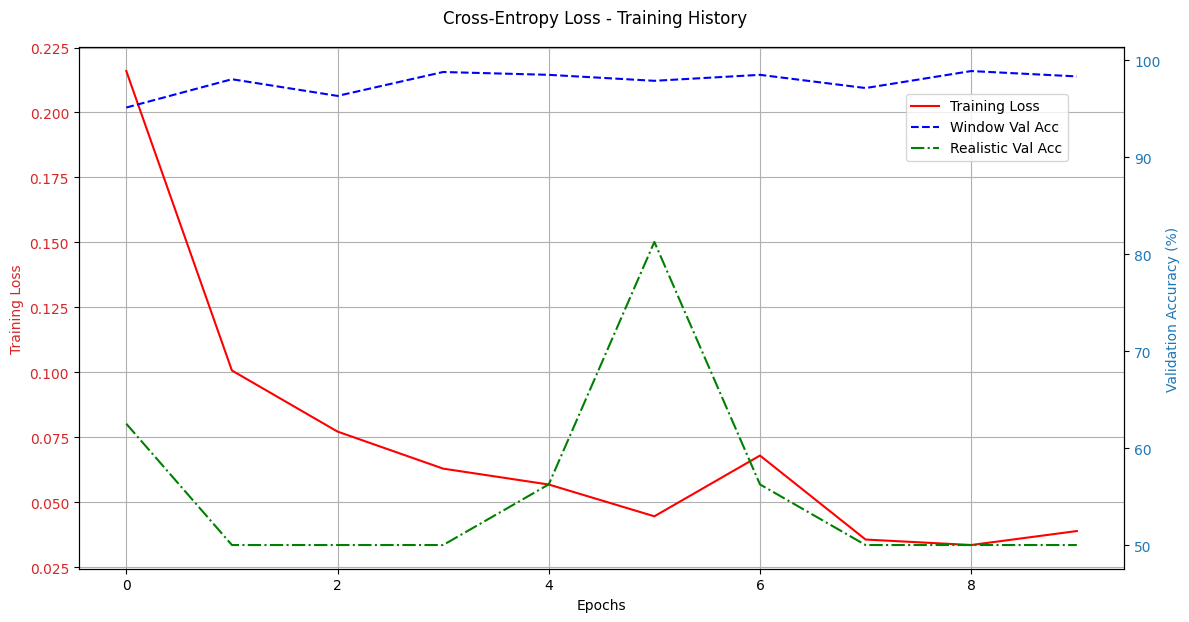


 Loading best model for final evaluation on the Test Set 
Global seed set to 42
Model loaded successfully from: best_ce_model_realistic.pth


Evaluating Test Set: 100%|██████████| 16/16 [00:03<00:00,  4.15it/s]




--- Test Set Evaluation (Per-Window) ---
                      precision    recall  f1-score   support

              Normal       0.97      0.95      0.96      1575
Potential Shoplifter       0.87      0.93      0.90       607

            accuracy                           0.94      2182
           macro avg       0.92      0.94      0.93      2182
        weighted avg       0.94      0.94      0.94      2182



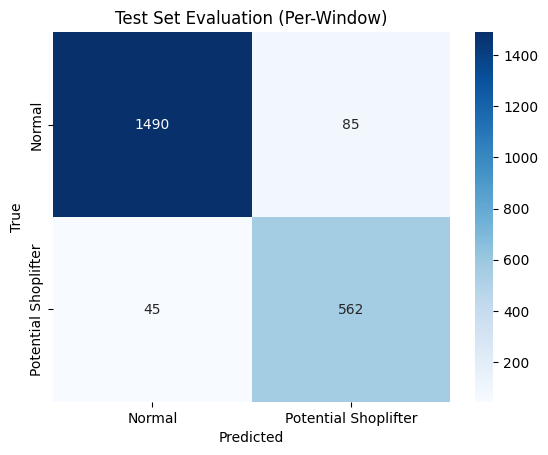


--- Test Set Evaluation (Simple Per-Video) ---
Accuracy (if any window is 1, predict 1): 50.00%

--- Test Set Evaluation (Optimal Threshold: 0.79) ---
                      precision    recall  f1-score   support

              Normal       1.00      1.00      1.00         8
Potential Shoplifter       1.00      1.00      1.00         8

            accuracy                           1.00        16
           macro avg       1.00      1.00      1.00        16
        weighted avg       1.00      1.00      1.00        16



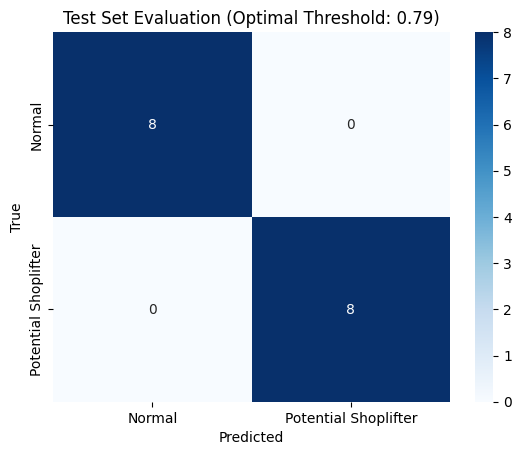

In [8]:
def plot_history(history: dict, trial_name: str):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Training Loss', color='tab:red')
    ax1.plot(history['train_loss'], 'r-', label='Training Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Validation Accuracy (%)', color='tab:blue')
    ax2.plot(history['val_acc_window'], 'b--', label='Window Val Acc')
    ax2.plot(history['val_acc_realistic'], 'g-.', label='Realistic Val Acc')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    fig.tight_layout()
    fig.suptitle(f'{trial_name} - Training History', y=1.03)
    fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
    plt.show()

print(" Plotting Training History for Trial 1 (Cross-Entropy) ")
plot_history(ce_history, "Cross-Entropy Loss")

print("\n Loading best model for final evaluation on the Test Set ")
set_seed(SEED)

final_ce_model = RealTimeClassifier(INPUT_FEATURES, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES).to(device)
final_ce_model.load_state_dict(torch.load(ce_model_path_realistic))
print(f"Model loaded successfully from: {ce_model_path_realistic}")

evaluate_and_report_on_test_set(
    model=final_ce_model,
    test_sequences=X_test_long,
    test_labels=y_test_long,
    device=device
)

 Loading best model optimized for per-window performance 
Global seed set to 42


Getting Per-Window Predictions: 100%|██████████| 18/18 [00:03<00:00,  4.96it/s]




Identified 4 videos with Shoplifter misclassifications.
Identified 8 videos with Normal Pedestrian misclassifications.


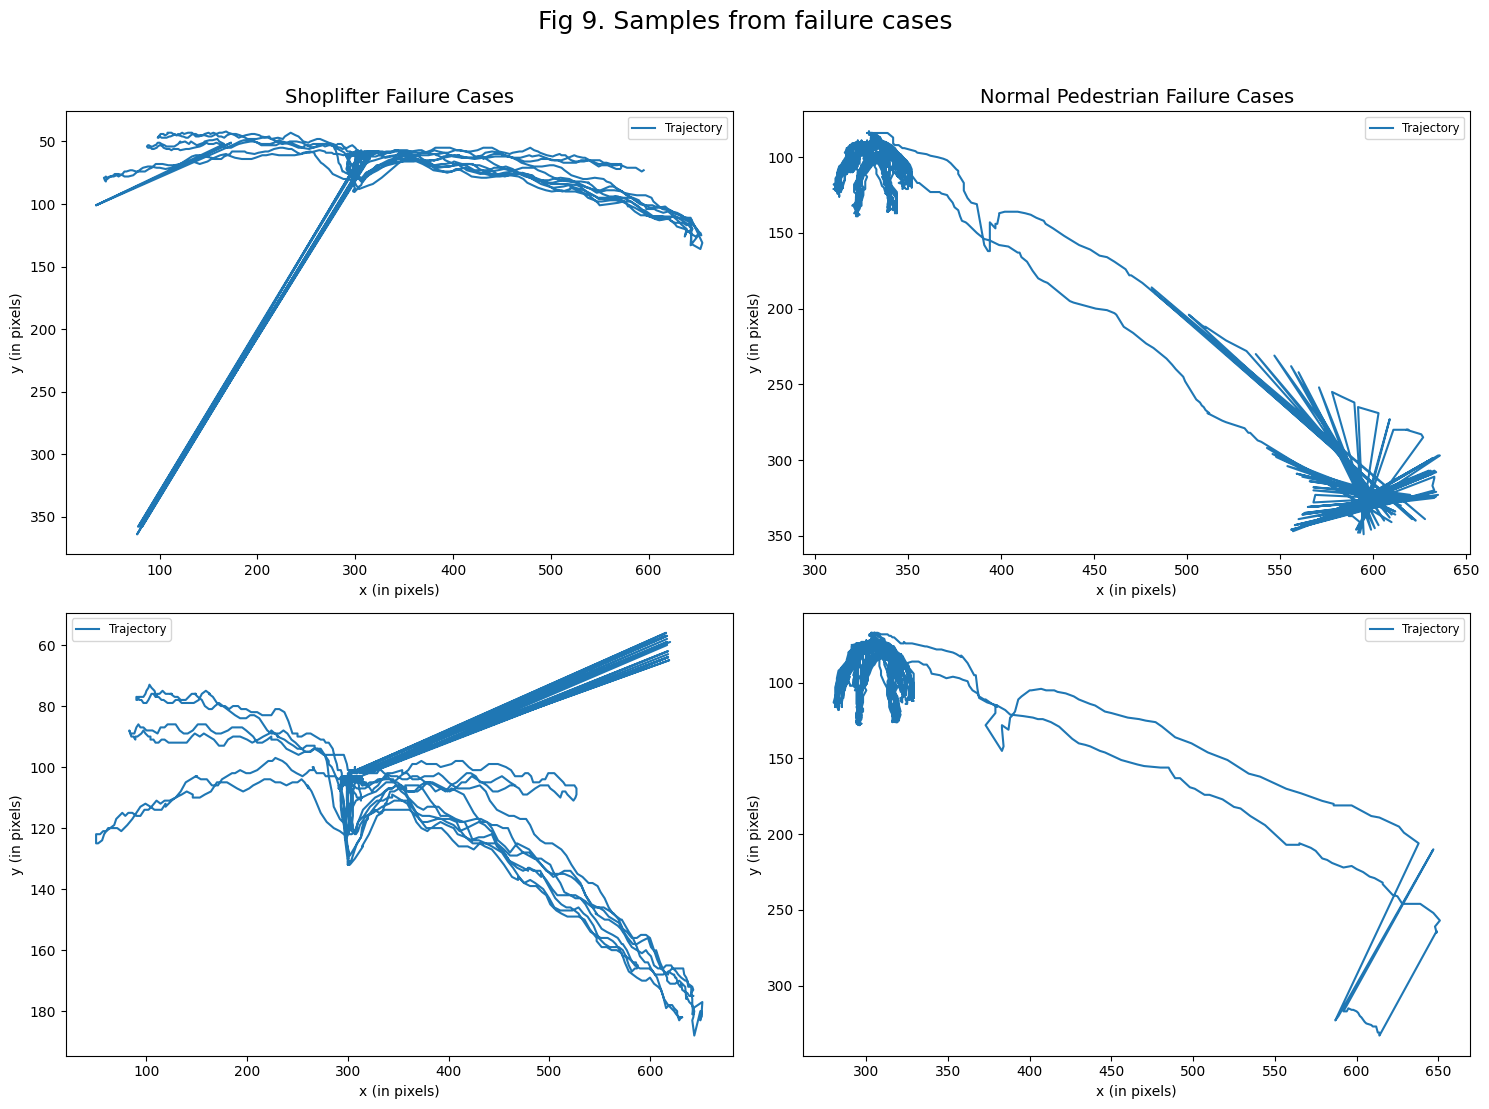

In [9]:
def plot_trajectory(csv_path: str, ax: plt.Axes):
    df = pd.read_csv(csv_path)
    if df.empty or 'POSES' not in df.columns:
        return
    raw_poses = np.array(df['POSES'].apply(parse_poses_from_string).tolist())
    neck_trajectory = raw_poses[:, 1, :]
    neck_trajectory = neck_trajectory[np.any(neck_trajectory != 0, axis=1)]
    if neck_trajectory.shape[0] > 1:
        ax.plot(neck_trajectory[:, 0], neck_trajectory[:, 1], label='Trajectory')
        ax.set_xlabel('x (in pixels)')
        ax.set_ylabel('y (in pixels)')
        ax.legend(fontsize='small')
        ax.invert_yaxis()

def create_sliding_windows_with_indices(sequences: list, labels: list, window_size: int, step_size: int):
    windowed_sequences, windowed_labels, windowed_source_indices = [], [], []
    for i, seq in enumerate(sequences):
        if seq.shape[0] >= window_size:
            for start in range(0, seq.shape[0] - window_size + 1, step_size):
                windowed_sequences.append(seq[start:start + window_size])
                windowed_labels.append(labels[i])
                windowed_source_indices.append(i)
    return np.array(windowed_sequences), np.array(windowed_labels), np.array(windowed_source_indices)

print(" Loading best model optimized for per-window performance ")
set_seed(SEED)

window_model = RealTimeClassifier(INPUT_FEATURES, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES).to(device)
window_model.load_state_dict(torch.load(ce_model_path_window))
window_model.eval()

X_test_windowed_data, y_test_windowed_labels, test_window_source_indices = create_sliding_windows_with_indices(
    X_test_long, y_test_long, WINDOW_SIZE_FRAMES, STEP_SIZE_FRAMES
)

test_windowed_dataset = TensorDataset(torch.from_numpy(X_test_windowed_data).float(), torch.from_numpy(y_test_windowed_labels).long())
test_windowed_loader = DataLoader(test_windowed_dataset, batch_size=BATCH_SIZE, shuffle=False)

all_window_preds = []
with torch.no_grad():
    for sequences, _ in tqdm(test_windowed_loader, desc="Getting Per-Window Predictions"):
        outputs = window_model(sequences.to(device))
        all_window_preds.extend(torch.max(outputs.data, 1)[1].cpu().numpy())

fn_video_indices = set()
fp_video_indices = set()
for i, (pred, true) in enumerate(zip(all_window_preds, y_test_windowed_labels)):
    if pred != true:
        source_idx = test_window_source_indices[i]
        if true == 1:
            fn_video_indices.add(source_idx)
        else:
            fp_video_indices.add(source_idx)

print(f"\nIdentified {len(fn_video_indices)} videos with Shoplifter misclassifications.")
print(f"Identified {len(fp_video_indices)} videos with Normal Pedestrian misclassifications.")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Fig 9. Samples from failure cases', fontsize=18, y=0.95)

fn_indices_list = list(fn_video_indices)
axes[0, 0].set_title('Shoplifter Failure Cases', fontsize=14)
for i, ax in enumerate(axes[:, 0]):
    if i < len(fn_indices_list):
        idx = fn_indices_list[i]
        plot_trajectory(test_paths_long[idx], ax)
    else:
        ax.set_visible(False)

fp_indices_list = list(fp_video_indices)
axes[0, 1].set_title('Normal Pedestrian Failure Cases', fontsize=14)
for i, ax in enumerate(axes[:, 1]):
    if i < len(fp_indices_list):
        idx = fp_indices_list[i]
        plot_trajectory(test_paths_long[idx], ax)
    else:
        ax.set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

In [10]:
print(" Trial 2: Training with Focal Loss ")

set_seed(SEED)

focal_model = RealTimeClassifier(INPUT_FEATURES, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES).to(device)

total_videos = 88 + 64
alpha_class_0 = 64 / total_videos
alpha_class_1 = 88 / total_videos
alpha_tensor = torch.tensor([alpha_class_0, alpha_class_1]).to(device)

print(f"Calculated alpha weights for Focal Loss: {alpha_tensor.cpu().numpy()}")

focal_criterion = FocalLoss(alpha=alpha_tensor, gamma=2.0)
focal_optimizer = optim.Adam(focal_model.parameters(), lr=0.001, weight_decay=1e-4)

focal_model_path_window = 'best_focal_model_window.pth'
focal_model_path_realistic = 'best_focal_model_realistic.pth'

focal_history = run_online_training_trial(
    model=focal_model,
    train_loader=train_loader,
    val_windowed_loader=val_windowed_loader,
    val_long_sequences=X_val_long,
    val_long_labels=y_val_long,
    criterion=focal_criterion,
    optimizer=focal_optimizer,
    num_epochs=NUM_EPOCHS,
    model_save_path_window=focal_model_path_window,
    model_save_path_realistic=focal_model_path_realistic,
    device=device
)

 Trial 2: Training with Focal Loss 
Global seed set to 42
Calculated alpha weights for Focal Loss: [0.42105263 0.57894737]


Epoch 1/10 | Training: 100%|██████████| 159/159 [01:29<00:00,  1.77it/s, loss=0.0143]



Epoch 1/10 | Train Loss: 0.0242 | Window Val Acc: 95.75% | Realistic Val Acc: 50.00%
---> New best WINDOW model saved (Val Acc: 95.75%)
---> New best REALISTIC model saved (Val Acc: 50.00%)


Epoch 2/10 | Training: 100%|██████████| 159/159 [01:37<00:00,  1.63it/s, loss=0.0122]



Epoch 2/10 | Train Loss: 0.0128 | Window Val Acc: 98.28% | Realistic Val Acc: 50.00%
---> New best WINDOW model saved (Val Acc: 98.28%)


Epoch 3/10 | Training: 100%|██████████| 159/159 [01:45<00:00,  1.50it/s, loss=0.0049]



Epoch 3/10 | Train Loss: 0.0102 | Window Val Acc: 97.63% | Realistic Val Acc: 50.00%


Epoch 4/10 | Training: 100%|██████████| 159/159 [02:11<00:00,  1.21it/s, loss=0.0015]



Epoch 4/10 | Train Loss: 0.0087 | Window Val Acc: 98.90% | Realistic Val Acc: 93.75%
---> New best WINDOW model saved (Val Acc: 98.90%)
---> New best REALISTIC model saved (Val Acc: 93.75%)


Epoch 5/10 | Training: 100%|██████████| 159/159 [01:49<00:00,  1.45it/s, loss=0.0176]



Epoch 5/10 | Train Loss: 0.0083 | Window Val Acc: 98.83% | Realistic Val Acc: 56.25%


Epoch 6/10 | Training: 100%|██████████| 159/159 [02:00<00:00,  1.31it/s, loss=0.0086]



Epoch 6/10 | Train Loss: 0.0074 | Window Val Acc: 97.92% | Realistic Val Acc: 87.50%


Epoch 7/10 | Training: 100%|██████████| 159/159 [02:03<00:00,  1.29it/s, loss=0.0077]



Epoch 7/10 | Train Loss: 0.0071 | Window Val Acc: 98.48% | Realistic Val Acc: 56.25%


Epoch 8/10 | Training: 100%|██████████| 159/159 [02:21<00:00,  1.12it/s, loss=0.0051]



Epoch 8/10 | Train Loss: 0.0064 | Window Val Acc: 99.12% | Realistic Val Acc: 75.00%
---> New best WINDOW model saved (Val Acc: 99.12%)


Epoch 9/10 | Training: 100%|██████████| 159/159 [02:28<00:00,  1.07it/s, loss=0.0045]



Epoch 9/10 | Train Loss: 0.0063 | Window Val Acc: 97.54% | Realistic Val Acc: 87.50%


Epoch 10/10 | Training: 100%|██████████| 159/159 [03:03<00:00,  1.15s/it, loss=0.0049]



Epoch 10/10 | Train Loss: 0.0071 | Window Val Acc: 98.02% | Realistic Val Acc: 56.25%

--- Finished Training Trial ---


 Plotting Training History for Trial 2 (Focal Loss) 


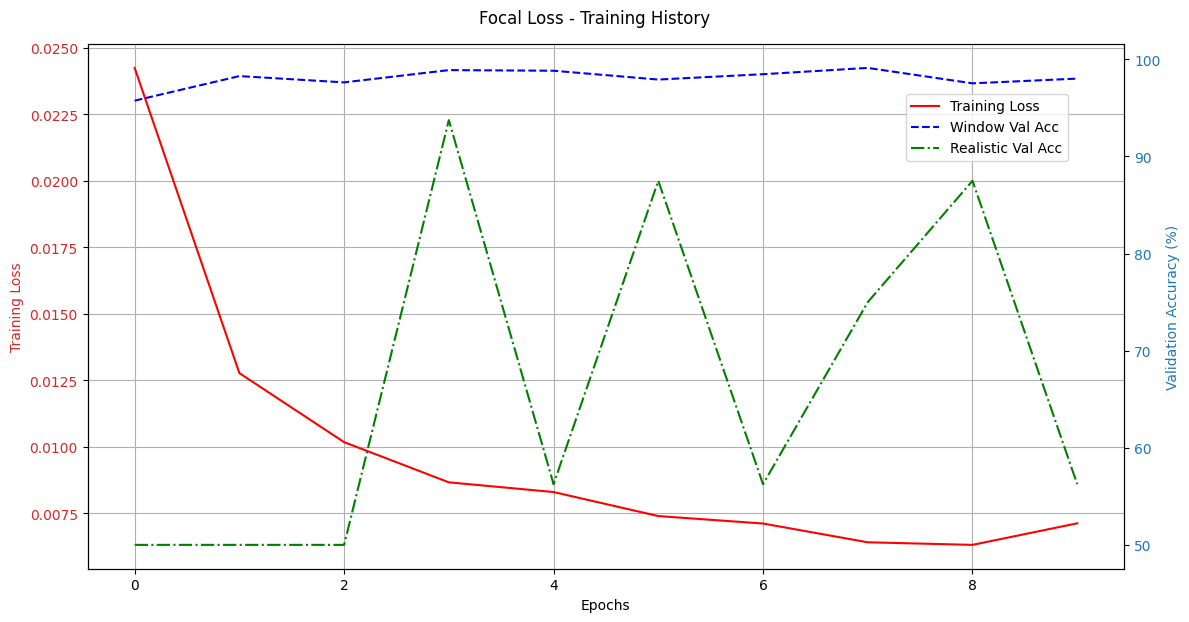


 Loading best Focal Loss model for final evaluation on the Test Set 
Global seed set to 42
Model loaded successfully from: best_focal_model_realistic.pth


Evaluating Test Set: 100%|██████████| 16/16 [00:01<00:00,  9.31it/s]


--- Test Set Evaluation (Per-Window) ---
                      precision    recall  f1-score   support

              Normal       0.97      0.95      0.96      1575
Potential Shoplifter       0.88      0.93      0.90       607

            accuracy                           0.94      2182
           macro avg       0.93      0.94      0.93      2182
        weighted avg       0.95      0.94      0.94      2182



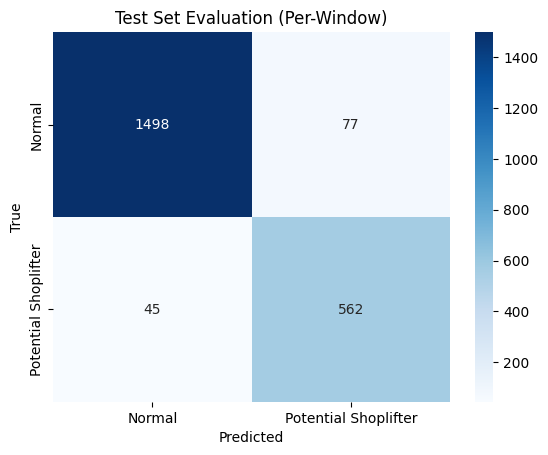


--- Test Set Evaluation (Simple Per-Video) ---
Accuracy (if any window is 1, predict 1): 50.00%

--- Test Set Evaluation (Optimal Threshold: 0.73) ---
                      precision    recall  f1-score   support

              Normal       1.00      1.00      1.00         8
Potential Shoplifter       1.00      1.00      1.00         8

            accuracy                           1.00        16
           macro avg       1.00      1.00      1.00        16
        weighted avg       1.00      1.00      1.00        16



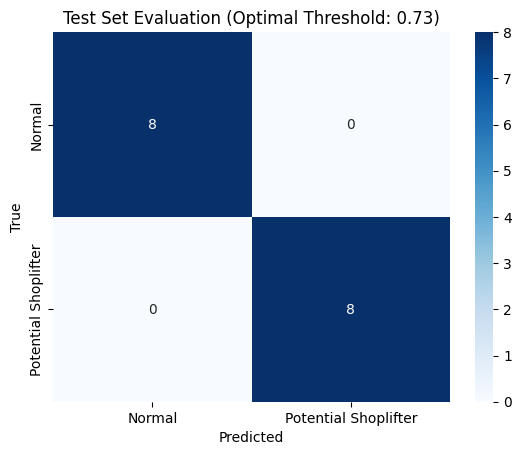


 Visualizing Failure Cases for Trial 2 (Focal Loss) 
Identified 0 total failure cases for the Focal Loss model.
 - 0 False Negatives (Missed Shoplifters)
 - 0 False Positives (Incorrectly Flagged Normals)
Identified 0 total failure cases for the Focal Loss model.
 - 0 False Negatives (Missed Shoplifters)
 - 0 False Positives (Incorrectly Flagged Normals)


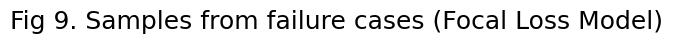

In [11]:
def get_model_predictions_for_test_set(model: nn.Module, test_sequences: list, test_labels: list, device: torch.device) -> list:
    model.eval()
    video_suspicion_scores = []

    with torch.no_grad():
        for long_seq_np in test_sequences:
            seq_windows_tensors = []
            if long_seq_np.shape[0] >= WINDOW_SIZE_FRAMES:
                for start in range(0, long_seq_np.shape[0] - WINDOW_SIZE_FRAMES + 1, STEP_SIZE_FRAMES):
                    window = long_seq_np[start:start + WINDOW_SIZE_FRAMES]
                    seq_windows_tensors.append(torch.from_numpy(window))
            if not seq_windows_tensors:
                video_suspicion_scores.append(0.0)
                continue
            windows_batch = torch.stack(seq_windows_tensors).float().to(device)
            outputs = model(windows_batch)
            probabilities = torch.softmax(outputs, dim=1)[:, 1]
            avg_suspicion_score = probabilities.mean().item()
            video_suspicion_scores.append(avg_suspicion_score)

    precisions, recalls, thresholds = precision_recall_curve(test_labels, video_suspicion_scores)
    f1_scores = np.nan_to_num(2 * (precisions * recalls) / (precisions + recalls))
    best_threshold = thresholds[np.argmax(f1_scores)]
    y_pred_thresholded = [1 if score >= best_threshold else 0 for score in video_suspicion_scores]
    return y_pred_thresholded

print(" Plotting Training History for Trial 2 (Focal Loss) ")
plot_history(focal_history, "Focal Loss")

print("\n Loading best Focal Loss model for final evaluation on the Test Set ")
set_seed(SEED)

final_focal_model = RealTimeClassifier(INPUT_FEATURES, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES).to(device)
final_focal_model.load_state_dict(torch.load(focal_model_path_realistic))
print(f"Model loaded successfully from: {focal_model_path_realistic}")

evaluate_and_report_on_test_set(
    model=final_focal_model,
    test_sequences=X_test_long,
    test_labels=y_test_long,
    device=device
)

print("\n Visualizing Failure Cases for Trial 2 (Focal Loss) ")

focal_test_predictions = get_model_predictions_for_test_set(final_focal_model, X_test_long, y_test_long, device)
focal_failure_indices = [i for i, (pred, true) in enumerate(zip(focal_test_predictions, y_test_long)) if pred != true]
fn_failures_focal = [i for i in focal_failure_indices if y_test_long[i] == 1]
fp_failures_focal = [i for i in focal_failure_indices if y_test_long[i] == 0]

print(f"Identified {len(focal_failure_indices)} total failure cases for the Focal Loss model.")
print(f" - {len(fn_failures_focal)} False Negatives (Missed Shoplifters)")
print(f" - {len(fp_failures_focal)} False Positives (Incorrectly Flagged Normals)")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Fig 9. Samples from failure cases (Focal Loss Model)', fontsize=18, y=0.95)

fn_indices_list_focal = list(fn_failures_focal)
axes[0, 0].set_title('UroKyoro Failure Cases', fontsize=14)
for i, ax in enumerate(axes[:, 0]):
    if i < len(fn_indices_list_focal):
        idx = fn_indices_list_focal[i]
        plot_trajectory(test_paths_long[idx], ax)
    else:
        ax.set_visible(False)

fp_indices_list_focal = list(fp_failures_focal)
axes[0, 1].set_title('Normal Pedestrian Failure Cases', fontsize=14)
for i, ax in enumerate(axes[:, 1]):
    if i < len(fp_indices_list_focal):
        idx = fp_indices_list_focal[i]
        plot_trajectory(test_paths_long[idx], ax)
    else:
        ax.set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

# visualizing

In [13]:
import torch
from sklearn.model_selection import GroupShuffleSplit
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import os
import json
import numpy as np
import pandas as pd
from glob import glob

SEED = 42
WINDOW_SIZE_FRAMES = 150
STEP_SIZE_FRAMES = 30
BATCH_SIZE = 128

INPUT_FEATURES = 73
HIDDEN_SIZE = 128
NUM_LAYERS = 2
NUM_CLASSES = 2

class RealTimeClassifier(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_rate=0.5):
        super(RealTimeClassifier, self).__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=False)
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.attention = torch.nn.Linear(hidden_size, 1)
        self.fc = torch.nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        attention_scores = self.attention(out)
        attention_weights = torch.softmax(attention_scores, dim=1)
        context_vector = torch.sum(attention_weights * out, dim=1)
        context_vector_dropped = self.dropout(context_vector)
        return self.fc(context_vector_dropped)

def parse_poses_from_string(poses_str: str) -> np.ndarray:
    try:
        return np.array(json.loads(poses_str)).reshape(18, 2)
    except (json.JSONDecodeError, ValueError):
        return np.zeros((18, 2))

def extract_features(csv_path: str) -> np.ndarray | None:
    df_features = pd.read_csv(csv_path)
    if df_features.empty or 'POSES' not in df_features.columns:
        return None
    raw_poses = np.array(df_features['POSES'].apply(parse_poses_from_string).tolist())
    neck_positions = raw_poses[:, 1:2, :]
    normalized_poses = raw_poses - neck_positions
    velocities = np.diff(raw_poses, axis=0, prepend=raw_poses[0:1])
    neck_trajectory = raw_poses[:, 1, :]
    deltas = np.diff(neck_trajectory, axis=0, prepend=[neck_trajectory[0]])
    orientation_angles_deg = np.degrees(np.arctan2(deltas[:, 1], deltas[:, 0]))
    return np.concatenate([
        normalized_poses.reshape(raw_poses.shape[0], -1),
        velocities.reshape(raw_poses.shape[0], -1),
        orientation_angles_deg.reshape(-1, 1)
    ], axis=1)

def get_group_id(file_path: str) -> str:
    return os.path.basename(file_path).replace('.csv', '')[-23:]

def create_sliding_windows(sequences: list, labels: list, window_size: int, step_size: int):
    windowed_sequences, windowed_labels = [], []
    for i, seq in enumerate(sequences):
        if seq.shape[0] >= window_size:
            for start in range(0, seq.shape[0] - window_size + 1, step_size):
                windowed_sequences.append(seq[start:start + window_size])
                windowed_labels.append(labels[i])
    return np.array(windowed_sequences), np.array(windowed_labels)

print(" Recreating the exact test set split ")

data_root =r'C:\\Users\\asus\\Desktop\\Ain-Guard Assesment\\csvs_Skeleton_poses_normal_potential_shoplifter'
search_pattern = os.path.join(data_root, '**', '*.csv')
all_csv_files = glob(search_pattern, recursive=True)
if not all_csv_files:
    raise FileNotFoundError(f"No CSV files were found using the pattern: {search_pattern}. Please check your data_root path.")

labeled_data = [{'path': file, 'label': 1 if 'Potential_shoplifter' in file else 0} for file in all_csv_files]
df_files = pd.DataFrame(labeled_data)

all_sequences, all_labels, all_groups, all_paths = [], [], [], []
for _, row in tqdm(df_files.iterrows(), total=len(df_files), desc="Extracting Features"):
    features = extract_features(row['path'])
    if features is not None and len(features) > 0:
        all_sequences.append(features)
        all_labels.append(row['label'])
        all_groups.append(get_group_id(row['path']))
        all_paths.append(row['path'])

gss_train_temp = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
train_group_indices, temp_group_indices = next(gss_train_temp.split(all_sequences, all_labels, all_groups))

temp_sequences = [all_sequences[i] for i in temp_group_indices]
temp_labels = [all_labels[i] for i in temp_group_indices]
temp_groups = np.array(all_groups)[temp_group_indices]
temp_paths = [all_paths[i] for i in temp_group_indices]

gss_val_test = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=SEED)
val_indices, test_indices = next(gss_val_test.split(temp_sequences, temp_labels, temp_groups))

X_test_long = [temp_sequences[i] for i in test_indices]
y_test_long = [temp_labels[i] for i in test_indices]
test_paths_long = [temp_paths[i] for i in test_indices]

print(f"\nSuccessfully recreated test set with {len(X_test_long)} videos.")

 Recreating the exact test set split 


Extracting Features: 100%|██████████| 152/152 [00:07<00:00, 20.79it/s]


Successfully recreated test set with 16 videos.


 Loading best model optimized for per-window performance 


Getting Per-Window Predictions: 100%|██████████| 18/18 [00:02<00:00,  8.83it/s]




Identified 4 videos with Shoplifter misclassifications (False Negatives).
Identified 8 videos with Normal misclassifications (False Positives).


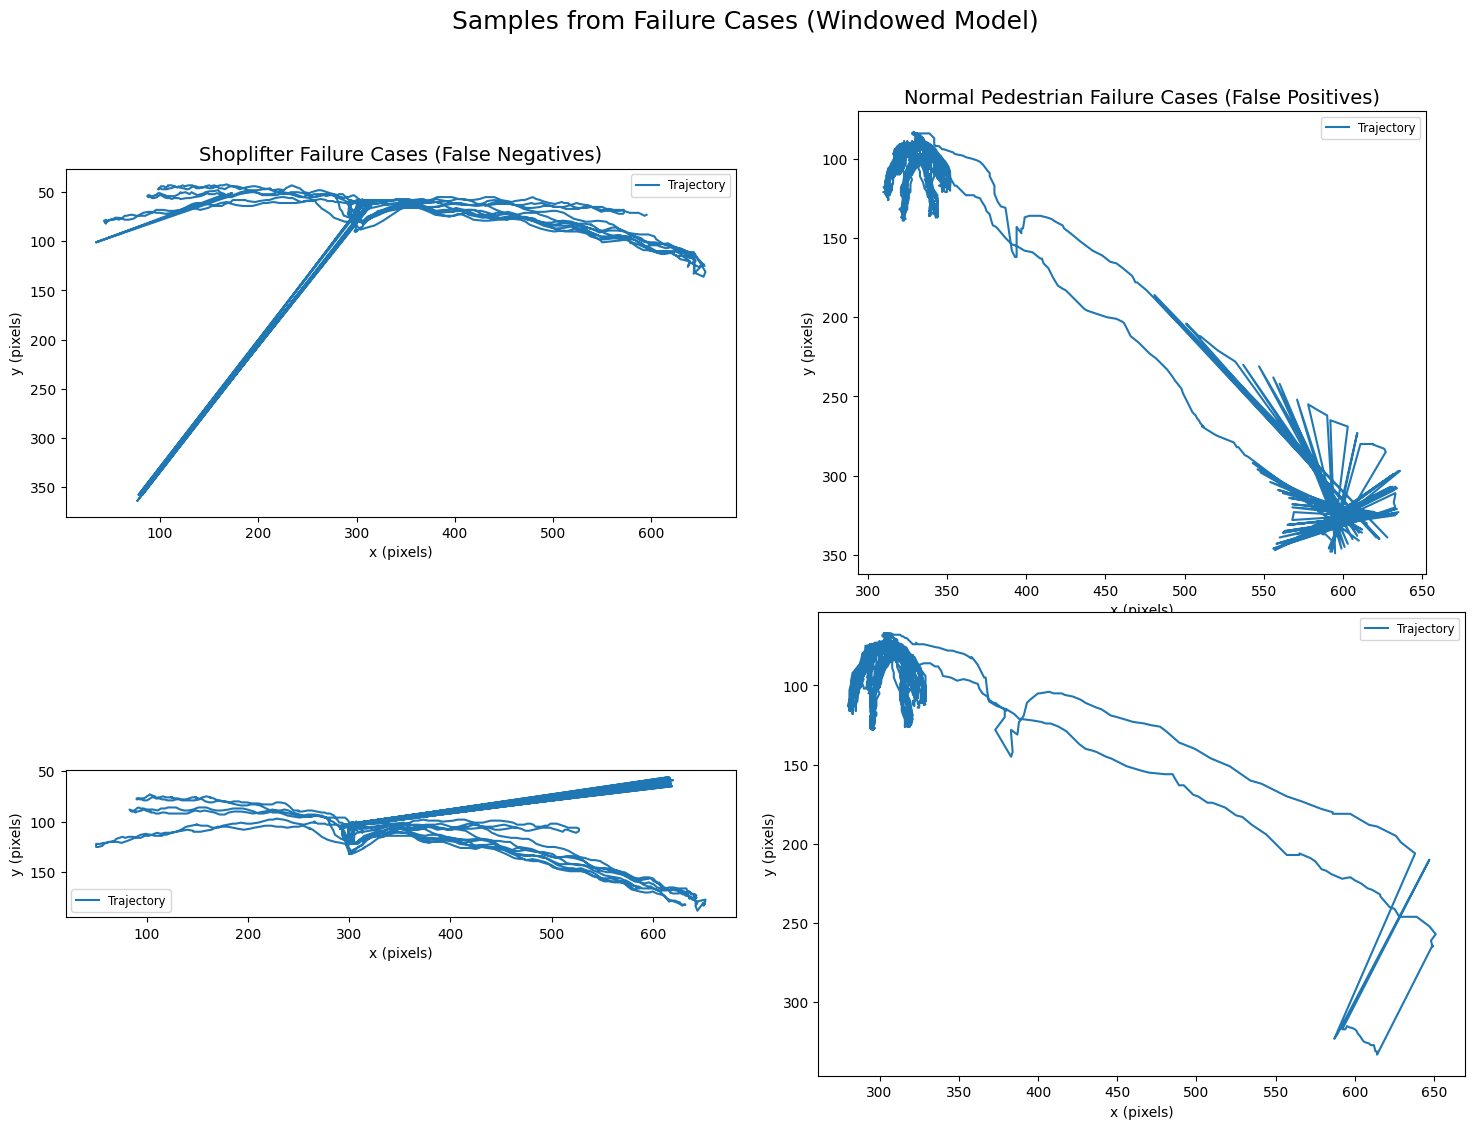

In [14]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def plot_trajectory(csv_path: str, ax: plt.Axes):
    df_plot = pd.read_csv(csv_path)
    if df_plot.empty or 'POSES' not in df_plot.columns:
        return
    raw_poses = np.array(df_plot['POSES'].apply(parse_poses_from_string).tolist())
    neck_trajectory = raw_poses[:, 1, :]
    neck_trajectory = neck_trajectory[np.any(neck_trajectory != 0, axis=1)]
    if neck_trajectory.shape[0] > 1:
        ax.plot(neck_trajectory[:, 0], neck_trajectory[:, 1], label='Trajectory')
        ax.set_xlabel('x (pixels)')
        ax.set_ylabel('y (pixels)')
        ax.legend(fontsize='small')
        ax.invert_yaxis()

def create_sliding_windows_with_indices(sequences: list, labels: list, window_size: int, step_size: int):
    windowed_sequences, windowed_labels, windowed_source_indices = [], [], []
    for i, seq in enumerate(sequences):
        if seq.shape[0] >= window_size:
            for start in range(0, seq.shape[0] - window_size + 1, step_size):
                windowed_sequences.append(seq[start:start + window_size])
                windowed_labels.append(labels[i])
                windowed_source_indices.append(i)
    return np.array(windowed_sequences), np.array(windowed_labels), np.array(windowed_source_indices)

print(" Loading best model optimized for per-window performance ")

model_path = 'best_ce_model_window.pth'
window_model = RealTimeClassifier(INPUT_FEATURES, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES).to(device)
window_model.load_state_dict(torch.load(model_path))
window_model.eval()

X_test_windowed, y_test_windowed_labels, test_window_source_indices = create_sliding_windows_with_indices(
    X_test_long, y_test_long, WINDOW_SIZE_FRAMES, STEP_SIZE_FRAMES
)

test_windowed_dataset = TensorDataset(torch.from_numpy(X_test_windowed).float(), torch.from_numpy(y_test_windowed_labels).long())
test_windowed_loader = DataLoader(test_windowed_dataset, batch_size=BATCH_SIZE, shuffle=False)

all_window_preds = []
with torch.no_grad():
    for sequences, _ in tqdm(test_windowed_loader, desc="Getting Per-Window Predictions"):
        outputs = window_model(sequences.to(device))
        all_window_preds.extend(torch.max(outputs.data, 1)[1].cpu().numpy())

fn_video_indices = set()
fp_video_indices = set()
for i, (pred, true) in enumerate(zip(all_window_preds, y_test_windowed_labels)):
    if pred != true:
        source_idx = test_window_source_indices[i]
        if true == 1:
            fn_video_indices.add(source_idx)
        else:
            fp_video_indices.add(source_idx)

print(f"\nIdentified {len(fn_video_indices)} videos with Shoplifter misclassifications (False Negatives).")
print(f"Identified {len(fp_video_indices)} videos with Normal misclassifications (False Positives).")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Samples from Failure Cases (Windowed Model)', fontsize=18, y=0.95)

fn_indices_list = list(fn_video_indices)
axes[0, 0].set_title('Shoplifter Failure Cases (False Negatives)', fontsize=14)
for i, ax in enumerate(axes[:, 0]):
    ax.set_aspect('equal', adjustable='box')
    if i < len(fn_indices_list):
        idx = fn_indices_list[i]
        plot_trajectory(test_paths_long[idx], ax)
    else:
        ax.set_visible(False)

fp_indices_list = list(fp_video_indices)
axes[0, 1].set_title('Normal Pedestrian Failure Cases (False Positives)', fontsize=14)
for i, ax in enumerate(axes[:, 1]):
    ax.set_aspect('equal', adjustable='box')
    if i < len(fp_indices_list):
        idx = fp_indices_list[i]
        plot_trajectory(test_paths_long[idx], ax)
    else:
        ax.set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.93])
plt.show()

In [15]:
import pandas as pd
import numpy as np
import cv2
import json
import os
from glob import glob

def save_sequence_as_video_final(pose_sequence: list, connections: list, output_path: str, fps: float = 15.0):
    if not pose_sequence:
        print(f"Warning: Empty pose sequence for {output_path}. Skipping.")
        return
    all_x = [kp[0] for pose in pose_sequence for kp in pose if kp[0] != 0]
    all_y = [kp[1] for pose in pose_sequence for kp in pose if kp[1] != 0]
    if not all_x or not all_y:
        print(f"Warning: No valid keypoints in sequence for {output_path}. Skipping.")
        return
    min_x, max_x = int(np.min(all_x)) - 20, int(np.max(all_x)) + 20
    min_y, max_y = int(np.min(all_y)) - 20, int(np.max(all_y)) + 20
    width, height = max_x - min_x, max_y - min_y
    output_dir = os.path.dirname(output_path)
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    for keypoints in pose_sequence:
        frame = np.full((height, width, 3), 255, dtype=np.uint8)
        limb_thickness, point_radius = 2, 3
        for i, j in connections:
            start_point_orig = keypoints[i]
            end_point_orig = keypoints[j]
            if start_point_orig.any() and end_point_orig.any():
                start_point = (int(start_point_orig[0] - min_x), int(start_point_orig[1] - min_y))
                end_point = (int(end_point_orig[0] - min_x), int(end_point_orig[1] - min_y))
                cv2.line(frame, start_point, end_point, (255, 0, 0), limb_thickness)
        for x, y in keypoints:
            if x != 0 and y != 0:
                cv2.circle(frame, (int(x - min_x), int(y - min_y)), point_radius, (0, 0, 255), -1)
        video_writer.write(frame)
    video_writer.release()
    print(f"> Saved video to: {output_path}")

def parse_poses_from_string(poses_str: str) -> np.ndarray:
    try:
        pose_list = json.loads(poses_str)
        return np.array(pose_list).reshape(18, 2)
    except (json.JSONDecodeError, ValueError):
        return np.zeros((18, 2))

YOUR_SKELETON_CONNECTIONS = [
    [0, 1], [1, 2], [2, 3], [3, 4],
    [1, 5], [5, 6], [6, 7],
    [1, 14], [14, 8], [14, 11],
    [8, 9], [9, 10],
    [11, 12], [12, 13]
]

try:
    fn_paths_to_visualize = [test_paths_long[i] for i in list(fn_video_indices)[:2]]
    fp_paths_to_visualize = [test_paths_long[i] for i in list(fp_video_indices)[:2]]
    files_to_visualize = fn_paths_to_visualize + fp_paths_to_visualize
except NameError:
    print("Error: Could not find failure case variables (e.g., 'fn_video_indices').")
    print("Please make sure you have successfully run the previous cell that identifies failure cases.")
    files_to_visualize = []

base_output_dir = 'failure_case_videos'
print(f" Generating videos for {len(files_to_visualize)} failure cases ")

for csv_path in files_to_visualize:
    path_parts = csv_path.split(os.sep)
    simple_path = os.path.join(*path_parts[-3:])
    output_video_path = os.path.join(base_output_dir, simple_path.replace('.csv', '.mp4'))
    if not os.path.exists(csv_path):
        print(f"File not found: {csv_path}. Skipping.")
        continue
    print(f"\nProcessing: {csv_path}")
    df = pd.read_csv(csv_path)
    pose_sequence = df['POSES'].apply(parse_poses_from_string).tolist()
    save_sequence_as_video_final(pose_sequence, YOUR_SKELETON_CONNECTIONS, output_video_path)

if files_to_visualize:
    print(f"\nAll selected videos have been generated in the '{base_output_dir}' folder!")

 Generating videos for 4 failure cases 

Processing: C:\\Users\\asus\\Desktop\\Ain-Guard Assesment\\csvs_Skeleton_poses_normal_potential_shoplifter\Potential_shoplifter\looking_right_left-hide_object\cam03_3m_state_looking_right_left-hide_object_2023_2_16_17_59_14_006.csv
> Saved video to: failure_case_videos\Potential_shoplifter\looking_right_left-hide_object\cam03_3m_state_looking_right_left-hide_object_2023_2_16_17_59_14_006.mp4

Processing: C:\\Users\\asus\\Desktop\\Ain-Guard Assesment\\csvs_Skeleton_poses_normal_potential_shoplifter\Potential_shoplifter\looking_right_left-hide_object\cam05_4m_state_looking_right_left-hide_object_2023_2_16_17_59_14_006.csv
> Saved video to: failure_case_videos\Potential_shoplifter\looking_right_left-hide_object\cam03_3m_state_looking_right_left-hide_object_2023_2_16_17_59_14_006.mp4

Processing: C:\\Users\\asus\\Desktop\\Ain-Guard Assesment\\csvs_Skeleton_poses_normal_potential_shoplifter\Potential_shoplifter\looking_right_left-hide_object\cam05_4m